# Importing Libraries

In [ ]:
# Imports
import os
import pandas as pd
import numpy as np
import torch
import glob
import logging
import pickle
import random
import re
import shutil

!pip install torchmetrics
from nltk.translate.bleu_score import sentence_bleu
from torchmetrics.text import WordErrorRate
from typing import Dict, List, Tuple
from pathlib import Path
from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

!pip -q install transformers
from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

from transformers import AutoModelWithLMHead, AutoTokenizer

loadGeneral, saveGeneral = 1, 0 # Flag to keep track of which model to finetune
urdu = 0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.1 MB/s eta 0:00:00


Most of the code for model architecture is courtesy of
https://github.com/ShafaqFatimaMughal/Kaavish-Mai-Transformer-Based-Urdu-Chatbot.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')
# os.chdir("/content/drive/My Drive/Colab Notebooks")
# path = "/content/drive/My Drive/Kaavish-Mai-Transformer-Based-Urdu-Chatbot/Datasets/"

# Cloning GitHub Repository

In [ ]:
!git clone https://github.com/ShafaqFatimaMughal/Kaavish-Mai-Transformer-Based-Urdu-Chatbot.git
path = "/content/Kaavish-Mai-Transformer-Based-Urdu-Chatbot/Datasets"

Cloning into 'Kaavish-Mai-Transformer-Based-Urdu-Chatbot'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 276 (delta 39), reused 96 (delta 36), pack-reused 171
Receiving objects: 100% (276/276), 11.27 MiB | 4.71 MiB/s, done.
Resolving deltas: 100% (117/117), done.


# Installings and Loading DialoGPT pretrained model
We use loadGeneral to dicipher whether to load DialoGPT small from HuggingFace or load DialoGPT small that has been pretrained on general Roman Urdu Conversations. 

In [ ]:
if saveGeneral or urdu==0:
  model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-small")
else:
  model = pickle.load(open('mai_general_model.pkl', 'rb'))  

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1322: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
"""
Fine-tuning the library models for language modeling on a text file (GPT, GPT-2, BERT, RoBERTa).
GPT and GPT-2 are fine-tuned using a causal language modeling (CLM) loss while BERT and RoBERTa are fine-tuned
using a masked language modeling (MLM) loss.
"""
# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [ ]:
# Args to allow for easy convertion of python script to notebook
class Args():
    def __init__(self):
        self.output_dir = 'output-small'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 1
        self.per_gpu_eval_batch_size = 1
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 1
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 5000
        self.save_steps = 10000
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

# Reading Files and Creating Merged Dataset

In [ ]:
import pandas as pd
from googletrans import Translator
from tqdm import tqdm

# Step 1: Load the dataset (Adjust based on actual file path)
data_path = "/kaggle/input/personachat/personality.csv"  # Example file path
dataset = df

# Step 2: Select only 3,000 rows for processing
dataset = dataset.head(3000)  # Select the first 3,000 rows

# Step 3: Initialize Google Translator
translator = Translator()

# Step 4: Function to translate text to Urdu
def translate_to_urdu(text):
    try:
        if text:  # Check if text is not empty
            translated = translator.translate(text, src='en', dest='ur')
            return translated.text
        return text
    except Exception as e:
        print(f"Error translating text: {text}, Error: {e}")
        return text

# Step 5: Translate selected rows
tqdm.pandas()  # Progress bar for pandas
dataset['Persona'] = dataset['Persona'].progress_apply(translate_to_urdu)
dataset['chat'] = dataset['chat'].progress_apply(translate_to_urdu)

# Step 6: Save the translated subset
output_path = "/kaggle/working/personachat_translated_urdu_subset.csv"  # Adjust if needed
dataset.to_csv(output_path, index=False, encoding='utf-8-sig')


In [12]:
import pandas as pd
df = pd.read_csv("/kaggle/input/subset/personachat_translated_urdu_subset (1).csv")
df

,Unnamed: 0,Persona,chat
0,0,مجھے گھروں کو دوبارہ بنانا پسند ہے مجھے شکار ک...,ہائے آپ کیسے کر رہے ہیں میں شکل میں رہنے کے لئ...
1,1,میری ماں میری سب سے اچھی دوست ہے میری چار بہنی...,ہائے آج آپ کیسے کر رہے ہیں\nمیں اپنی بہنوں کے ...
2,2,میں نے کل رات مقامی تھیٹر میں ایک ٹمٹمائی کی ت...,ہم سب ایک پیلے رنگ کی سب میرین میں ایک پیلے رن...
3,3,میں بہت ایتھلیٹک ہوں میں رابطے پہنتا ہوں میرے ...,ہائے میں ایک نفیس باورچی کے طور پر کام کرتا ہو...
4,4,میں بنیادی طور پر ایک گوشت کھانے والا ہوں میں ...,آج آپ کیسے کر رہے ہیں؟\nاگر آپ دلچسپی رکھتے ہی...
...,...,...,...
2995,2995,میں ایک شائستہ بیکر ہوں میں ریٹائر ہونے کا منت...,ہیلو کیا آپ کے پاس کوئی بہن بھائی ہے؟\nنہیں ، ...
2996,2996,میں ہر دن ہر دن سورج طلوع ہوتے دیکھنے کے لئے ج...,ہائے آج آپ کیسے کر رہے ہیں\nمیں تھکا ہوا ہوں م...
2997,2997,میں شادی شدہ ہوں اور بچوں سے ہوں مجھے شاپنگ سے...,ارے وہاں کیسے ہیں؟\nارے میں اچھا کر رہا ہوں آپ...
2998,2998,مجھے وکٹورین چیزیں پسند ہیں میں ایک رومانٹک ہو...,ہائے آج آپ کیسے کر رہے ہیں\nمیں صرف اپنی نوادر...


In [13]:


# Split each line into question and answer
questions = df['Persona']
answers = df['chat']


# Create a DataFrame
df = pd.DataFrame({'Question': questions, 'Answer': answers})

# Display the DataFrame
print(df)

                                               Question  \
0     مجھے گھروں کو دوبارہ بنانا پسند ہے مجھے شکار ک...   
1     میری ماں میری سب سے اچھی دوست ہے میری چار بہنی...   
2     میں نے کل رات مقامی تھیٹر میں ایک ٹمٹمائی کی ت...   
3     میں بہت ایتھلیٹک ہوں میں رابطے پہنتا ہوں میرے ...   
4     میں بنیادی طور پر ایک گوشت کھانے والا ہوں میں ...   
...                                                 ...   
2995  میں ایک شائستہ بیکر ہوں میں ریٹائر ہونے کا منت...   
2996  میں ہر دن ہر دن سورج طلوع ہوتے دیکھنے کے لئے ج...   
2997  میں شادی شدہ ہوں اور بچوں سے ہوں مجھے شاپنگ سے...   
2998  مجھے وکٹورین چیزیں پسند ہیں میں ایک رومانٹک ہو...   
2999  میں نے بہت ساری کتابیں پڑھی ہیں مجھے شارک پسند...   

                                                 Answer  
0     ہائے آپ کیسے کر رہے ہیں میں شکل میں رہنے کے لئ...  
1     ہائے آج آپ کیسے کر رہے ہیں\nمیں اپنی بہنوں کے ...  
2     ہم سب ایک پیلے رنگ کی سب میرین میں ایک پیلے رن...  
3     ہائے میں ایک نفیس باورچی کے طور پر کام کرتا ہو...  
4

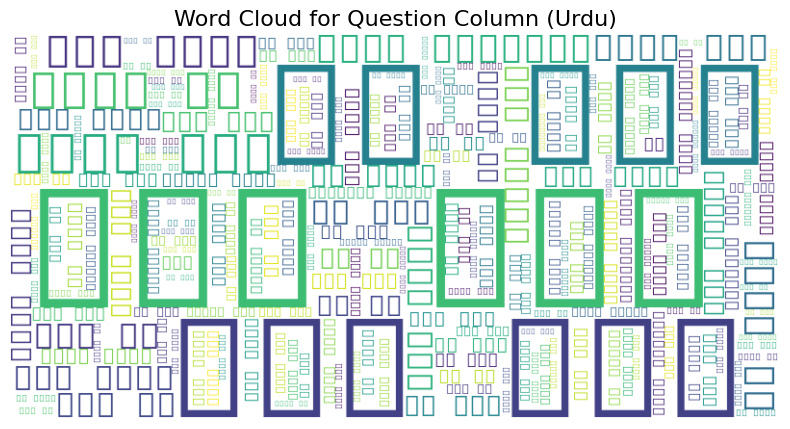

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Visualization: Word Cloud for "Question" Column
text_combined = " ".join(df["Question"].tolist())
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text_combined)

# Plot Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Question Column (Urdu)", fontsize=16)
plt.show()


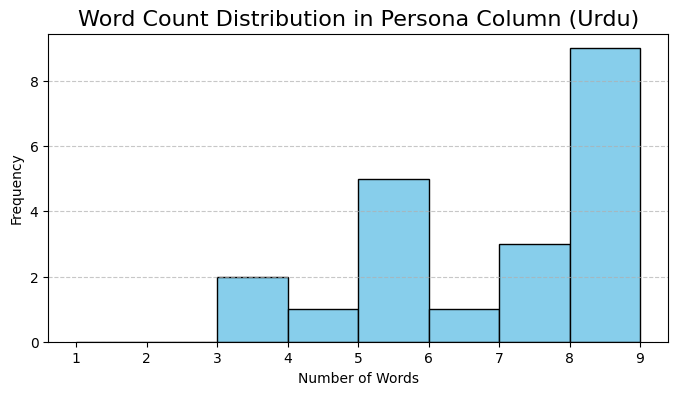

In [15]:
# Visualization: Word Count Distribution
df['Persona_Word_Count'] = df['Question'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
plt.hist(df['Persona_Word_Count'], bins=range(1, 10), color='skyblue', edgecolor='black')
plt.title("Word Count Distribution in Persona Column (Urdu)", fontsize=16)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.xticks(range(1, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


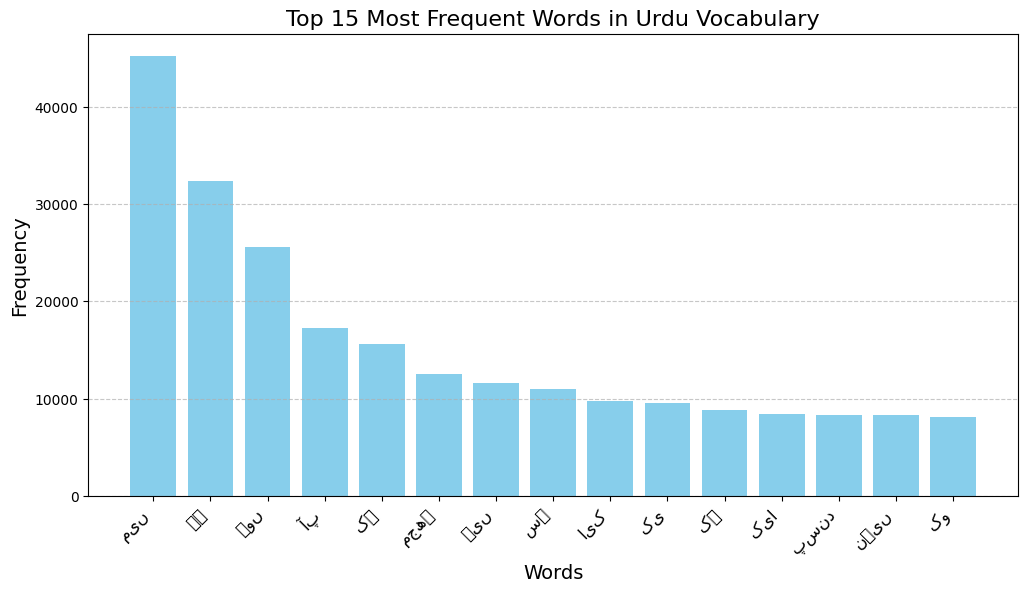

In [17]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
all_text = " ".join(df["Question"].tolist() + df["Answer"].tolist())

# Tokenize and count word frequencies
word_counts = Counter(all_text.split())

# Get the top 15 most frequent words
most_common_words = word_counts.most_common(15)

# Separate words and their frequencies for plotting
words, counts = zip(*most_common_words)

# Plot the vocabulary distribution
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="skyblue")
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top 15 Most Frequent Words in Urdu Vocabulary", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
trn_df, val_df = train_test_split(df1, test_size = 0.1)
trn_df.head()

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
431,What is progesterone,Estrogen is a hormone that is mainly found in ...,What is estrogen,Symptoms of low progesterone can include irreg...,how do i know if my progesterone is low,The symptoms of high progesterone can include ...,how do i know if my progesterone is high,High estrogen levels can cause a variety of sy...
1100,"Yes it is! Before ovulation, the ovarian cycle...",Is the ovarian cycle also part of the menstrua...,Sure! There are hormones that are involved and...,Can you tell if hormones play a role in the me...,"Take care, bye","No, bye","No problem, do you have any more questions for...",Thank you for answering my questions
537,ive a question.,Hello! How are you feeling today?,hi,WSalam.,salam,Painful period cramps could be caused by heavy...,what about extreme amounts of pain?,Mild back pain is normal and is a symptom of m...
378,"During ovulation, which typically occurs aroun...",Why do i feel so energetic around the time of ...,"It varies from person to person, but some wome...",At what point in the menstrual cycle do women ...,"It varies from person to person, but some wome...",Is there a particular time during the menstrua...,"It varies from person to person, but some wome...",During which phase of the menstrual cycle do w...
988,Mild back pain is normal and is a symptom of m...,Is it normal for my back to hurt during my per...,Food does not have anything to do with your flow!,What about foods like tamarind and curd?,Yes you can!,Can I eat what I normally eat during my period?,By taking care of menstruation you can avoid p...,Why is it important to take care of yourself d...


In [ ]:
!nvidia-smi

Wed May  3 11:01:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

import gc
gc.collect()

8

# Constructing Model

In [ ]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [ ]:
# Cacheing and storing of data/checkpoints
def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

In [ ]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: 
              continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of some model
def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    Word_Error_Rate = WordErrorRate()

    # Custom BLEU
    custom_data_loader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=1, collate_fn=collate, drop_last = True
    )
    bleu_loss_2 = 0.0
    bleu_loss_4 = 0.0
    WER = 0.0

    vals = 0
    for batch in tqdm(custom_data_loader, desc="BLEU"):
        inputs, labels = (batch, batch)
        if inputs.shape[1] > 1024: 
              continue
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)
        
        with torch.no_grad():
            predicted = model.generate(
                inputs, max_length=1000,
                pad_token_id=tokenizer.eos_token_id,  
                no_repeat_ngram_size=3,       
                do_sample=True, 
                top_k=100, 
                top_p=0.7,
                temperature = 0.8
                )
            y = tokenizer.decode(labels[:][0], skip_special_tokens=True).split()
            y_hat = tokenizer.decode(predicted[:][0], skip_special_tokens=True).split()

            # Word Error Rate
            WER_ = Word_Error_Rate(y_hat, y)
            WER += WER_

            # BLEU 
            bleu_2 = sentence_bleu([y], y_hat, weights=(0.5, 0.5, 0, 0))
            bleu_4 = sentence_bleu([y], y_hat, weights=(0.25, 0.25, 0.25, 0.25))
            bleu_loss_2 += bleu_2
            bleu_loss_4 += bleu_4
        vals += 1

    # Perplexity Calculation
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        if inputs.shape[1] > 1024: 
              continue
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)
        
        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"Perplexity": perplexity, 
              "BLEU-2": bleu_loss_2 / vals, 
              "BLEU-4": bleu_loss_4 / vals, 
              "Word Error Rate:": float(WER) / vals}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

# Model Training

In [ ]:
# Main runner
def main(df_trn, df_val):
    args = Args()
    
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)
    
    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [ ]:
main(trn_df, val_df)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1322: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1466 [00:00<?, ?it/s]

BLEU:   0%|          | 0/163 [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

Evaluating:   0%|          | 0/163 [00:00<?, ?it/s]

{'Perplexity_': tensor(5.2420),
 'BLEU-2_': 0.9242581331356546,
 'BLEU-4_': 0.9236302049003381,
 'Word Error Rate:_': 0.007131756449038265}